# BINARY CLASSIFIER WITH BERT

In [3]:
!pip install --upgrade tensorflow-hub
!pip install sentencepiece
!pip install matplotlib
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install spacytextblob
!python -m spacy download en_core_web_lg
!pip install -U nltk
!pip install gensim
!pip install python-Levenshtein
!pip install ftfy
!pip install pycld2
!pip install emoji
#!wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached pip-21.2.4-py3-none-any.whl (1.6 MB)
  Using cached setuptools-57.4.0-py3-none-any.whl (819 kB)
  Using cached wheel-0.37.0-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfull

__Hyparameter recommendations__: https://mccormickml.com/2019/07/22/BERT-fine-tuning/  
For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [1]:
# SELECT VERSION OF BERT: https://tfhub.dev/google/collections/bert/1    (SECTION "BERT models")
# MODEL USAGE IS ON THE PAGE FOR EACH MODEL!!!
# 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'       #(L=12 hidden layers, hidden size H=768, A=12 attention heads)
# 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4'      #(L=24 hidden layers, hidden size H=1024, A=16 attention heads)
# 'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4'  # same with whole word masking (recent update)
# There are also 3 cased versions, a chinese version, and a multilingual cased version

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'    # outdated from the article

In [2]:
import numpy as np
import pandas as pd
import string
import itertools
import time
import os
import re
import sklearn
import spacy
import pickle
import gc

from sklearn.metrics import classification_report, confusion_matrix
from text_preprocess import unfold_contractions, remove_emoji

import tensorflow_hub as hub
import tokenization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import ( Activation, Dropout, Dense, SpatialDropout1D, Embedding,
                                      Input, Concatenate, Reshape, Flatten, Bidirectional, LSTM, )

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
def plot_confusion_matrix(cm, classes,                      
                          title='CONFUSION MATRIX',
                          cmap=plt.cm.PuBu):         # originally plt.cm.Blues; also good: BuPu,RdPu,PuRd,OrRd,Oranges
    '''
    Plot the confusion matrix    
    '''
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
            
    plt.figure(figsize=(4,4))
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.tight_layout()
    plt.show()

In [4]:
# DIFFERENT TEXT CLEANING METHODS
def remove_digits(s):
    s = s.translate( str.maketrans(string.digits, ' '*len(string.digits)) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_punct(s):
    '''
    To avoid words being glued together, replace punct with spaces because
    there are complex words with '-' separator,
    and some people forget there should be a space after punctuation
    '''
    s = s.translate( str.maketrans(string.punctuation, ' '*len(string.punctuation) ) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_non_alpha(s):
    '''
    To avoid words being glued together, replace punct with spaces because
    there are complex words with '-' separator,
    and some people forget there should be a space after punctuation
    '''
    s = s.translate( str.maketrans( punctuation, ' '*len(punctuation) ) )
    s = s.translate( str.maketrans( string.digits, ' '*len(string.digits) ) )
    s = re.sub('\s+', ' ', s)
    return s.strip()

def remove_stopwords(s):
    s = s.strip().split()
    s = [ w.strip() for w in s if remove_non_alpha(w).lower() not in sw ]
    return ' '.join(s)

def mask_entities(s):
    '''
        Replace simplified named entities with their type,
        if a word is named entity; otherwise, lemmatize word
    '''    
    #ent_types = { 
    #                'number':  ['CARDINAL', 'ORDINAL', 'QUANTITY'],
    #                'place':   ['GPE', 'LOC', 'FAC'],
    #                'name':    ['PERSON', 'ORG'],
    #                'percent': ['PERCENT'],
    #                'money':   ['MONEY'],
    #                'date':    ['DATE'],
    #             }
    
    ent_types = { 
                    'number':       ['CARDINAL', 'ORDINAL'],
                    'place':        ['LOC'],
                    'name':         ['PERSON'],
                    'percent':      ['PERCENT'],
                    'money':        ['MONEY'],
                    'organization': ['ORG'],
                }
        
    # replace entities w/generic names, lemmatize
    out = []
    s = nlp(s)
    for t in s:
        ent_type = ''
        for key in ent_types:
            if t.ent_type_ in ent_types[key]:
                ent_type = key
                break
        if ent_type:
            out.append( ent_type )
        else:
            out.append( t.text )
        
    # remove words repeated seVeral times in a row
    stack = ['',]
    for item in out:
        if item == stack[-1]:
            continue
        stack.append( item )        
        
    return ' '.join( stack[1:] )

def convert_emoticons(s):
    return s.replace(':)', 'happy_face').replace(':D', 'happy_face')

punctuation = ''.join([c for c in string.punctuation if c not in "'!?"])
sw = [ 'a', 'an', 'the', 'of', ]

In [5]:
def dedupe( df1, df2, col_ ):
    '''
        df2 should not contain annything from df1 in column col_
        (e.g. df2 = smaller test set OR smaller set for 1 category)
        to preserve smaller df2, duplicates are deleted from df1
    '''
    original_length = df1.shape[0]
    df2_sents = df2[col_].values
    df1 = df1[ ~df1[col_].isin(df2_sents) ]
    print( f'\tDropping {original_length - df1.shape[0]} duplicates')
    return df1, df2

def upsample( df_, to_oversample_ ):
    '''
        Upsample df_ by to_oversample_ more samples    
    '''    
    replace = False
    if len(df_) < to_oversample_:
        replace = True
        
    df_upsampled = df_.sample( n=to_oversample_, replace=replace )
    df_          = pd.concat([ df_, df_upsampled ])
    return df_.sample( frac=1 )

def intersect_length( df1, df2, col_ ):
    '''
        Return counts of the same records in df1 and df2 in column col_    
    '''    
    len1 = len([ i for i in df1[col_].values if i in df2[col_].values ])
    len2 = len([ i for i in df2[col_].values if i in df1[col_].values ])
    return len1, len2

## 1. Prepare data

In [ ]:
file = ''
df   = pd.read_csv( file , sep='\t', encoding='utf-8' )

print( 'Data size:', df.shape )
print( 'Unique sentences:', len( df['sentence'].unique() ), '\n' )
print( 'Missing values:\n\n', df.isna().sum(), sep='' )
df.head(2)

In [8]:
nlp = spacy.load("en_core_web_lg")
nlp.remove_pipe('parser')
ml_categories = [ ]
len( ml_categories )

15

In [9]:
df = df[ df['is_subtle'] == 0 ]
df = df[ df['label'].isin( ml_categories ) ]
df = df.drop(['award_reason', 'is_group_award', 'group_award_id', 'keywords'], axis=1)

df['target'] = df['label'].apply( lambda x: 0 if x == 'unk' else 1 )

In [10]:
# DEDUPE BETWEEN CATEGORIES. FAVOR CATEGORY 1
print(df.shape)
df1 = df[ df['target'] == 1 ].copy()
df0 = df[ df['target'] == 0 ].copy()
df0, df1 = dedupe( df0, df1, 'sentence' )
df = pd.concat([ df0, df1 ]).copy().sample(frac=1).reset_index(drop=True)
print(df.shape)

(9438, 11)
	Dropping 4 duplicates
(9434, 11)


In [11]:
# DEDUPE TRAIN / VAL / TEST SETS. FAVOR TEST, THEN VAL SET
print(df.shape)
df_train = df[ df['subset'] == 'train' ].copy()
df_val   = df[ df['subset'] == 'val' ].copy()
df_test  = df[ df['subset'] == 'test' ].copy()

df_train, df_test = dedupe( df_train, df_test, 'sentence' )
df_val, df_test   = dedupe( df_val, df_test, 'sentence' )
df_train, df_val  = dedupe( df_train, df_val, 'sentence' )
df = pd.concat([ df_train, df_val, df_test ]).copy().sample(frac=1).reset_index(drop=True)
print(df.shape)

(9434, 11)
	Dropping 56 duplicates
	Dropping 21 duplicates
	Dropping 37 duplicates
(9320, 11)


In [12]:
print( 'Cleaning text ...', end=' ')
df['sentence_lower'] = df['sentence'].apply( mask_entities )
df['sentence_lower'] = df['sentence_lower'].apply( convert_emoticons )
df['sentence_lower'] = df['sentence_lower'].apply( lambda x: remove_emoji(x, to_text=True) )
df['sentence_lower'] = df['sentence_lower'].apply( lambda x: x.lower() )
df['sentence_lower'] = df['sentence_lower'].apply( unfold_contractions )
df['sentence_lower'] = df['sentence_lower'].apply( remove_non_alpha )
#df['sentence_lower'] = df['sentence_lower'].apply( remove_stopwords )
print('Done!')

# UNIQUE WORDS (very approx. because punctuation may be included)
num_words_cased   = len(set(' '.join(df['sentence'].tolist()).split()))
num_words_uncased = len(set(' '.join(df['sentence_lower'].tolist()).split()))
print( 'Unique cased words (uncleaned):' , num_words_cased )
print( 'Unique uncased words:          ' , num_words_uncased )

df['length'] = df['sentence_lower'].apply( lambda x: len(x.split()) )
maxlen       = df['length'].max()
print( 'Maximum sentence length:', maxlen, '\n' )

Cleaning text ... Done!
Unique cased words (uncleaned): 18756
Unique uncased words:           8591
Maximum sentence length: 96 



In [13]:
X_train = df[ df['subset'].isin([ 'train', 'val' ]) ]['sentence_lower'].values
y_train = df[ df['subset'].isin([ 'train', 'val' ]) ]['target'].values
X_test  = df[ df['subset'].isin([ 'test' ]) ]['sentence_lower'].values
y_test  = df[ df['subset'].isin([ 'test' ]) ]['target'].values

X_train, y_train = sklearn.utils.shuffle( X_train, y_train )
X_test, y_test   = sklearn.utils.shuffle( X_test, y_test )

print('Shape of train / test data:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shape of train / test data: (8509,) (811,) (8509,) (811,)


In [14]:
# SEE HOW TEXT WAS CLEANED
#for i in df[ df['subset'].isin([ 'train', 'val' ]) ][['sentence','sentence_lower','label','target']].values[:100]:
#    print(i[0])
#    print(i[1])
#    print(i[2], i[3])
#    print('='*100)

In [16]:
df['target'].value_counts()

0    4892
1    4428
Name: target, dtype: int64

In [17]:
del df_train, df_val, df_test, df

In [18]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [19]:
bert_layer    = hub.KerasLayer(module_url, trainable=True)
vocab_file    = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer     = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [20]:
maxlen = 100

In [21]:
# PASS RAW TEXT AS DF VALUES AND LABELS AS DF VALUES
X_train_encoded  = bert_encode(X_train, tokenizer, max_len=maxlen)
X_test_encoded   = bert_encode(X_test, tokenizer, max_len=maxlen)

In [22]:
x_train_encoded_path = 'data/X_train_encoded.pkl'
y_train_path         = 'data/y_train.pkl'
x_test_encoded_path  = 'data/X_test_encoded.pkl'
y_test_path          = 'data/y_test.pkl'

bert_layer_path    = 'data/bert_layer.pkl'
vocab_file_path    = 'data/bert_vocab_file.pkl'
do_lower_case_path = 'data/bert_do_lower_case.pkl'
tokenizer_path     = 'data/bert_tokenizer.pkl'

In [23]:
with open(x_train_encoded_path, 'wb') as f:
    pickle.dump( X_train_encoded, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(y_train_path, 'wb') as f:
    pickle.dump( y_train, f, protocol=pickle.HIGHEST_PROTOCOL )   
    
with open(x_test_encoded_path, 'wb') as f:
    pickle.dump( X_test_encoded, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(y_test_path, 'wb') as f:
    pickle.dump( y_test, f, protocol=pickle.HIGHEST_PROTOCOL )

In [24]:
with open(vocab_file_path, 'wb') as f:
    pickle.dump( vocab_file, f, protocol=pickle.HIGHEST_PROTOCOL )
    
with open(do_lower_case_path, 'wb') as f:
    pickle.dump( do_lower_case, f, protocol=pickle.HIGHEST_PROTOCOL )

with open(tokenizer_path, 'wb') as f:
    pickle.dump( tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL )

## 2. Train model

In [6]:
x_train_encoded_path = 'data/X_train_encoded.pkl'
y_train_path         = 'data/y_train.pkl'
x_test_encoded_path  = 'data/X_test_encoded.pkl'
y_test_path          = 'data/y_test.pkl'
tokenizer_path       = 'data/bert_tokenizer.pkl'

maxlen = 100

In [7]:
# LOAD DATA
with open(x_train_encoded_path, 'rb') as f:
    X_train_encoded = pickle.load( f )
    
with open(y_train_path, 'rb') as f:
    y_train = pickle.load( f )
    
with open(x_test_encoded_path, 'rb') as f:
    X_test_encoded = pickle.load( f )
    
with open(y_test_path, 'rb') as f:
    y_test = pickle.load( f )

In [8]:
# LOAD BERT COMPONENTS
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load( f )

In [12]:
def build_model( 
                 learning_rate,                 
                 dropout,
                 optimizer,
                 max_len=512,
               ):
        
    word_ids    = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    mask        = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    bert_layer = hub.KerasLayer(module_url, trainable=True)
    # model_path = "path/to/tfhubmodel/"                                # instead of loading every time
    # hub_layer = hub.KerasLayer(hub.load(model_path))
    _, sequence_output = bert_layer([word_ids, mask, segment_ids])
    bert_output = sequence_output[:, 0, :]
        
    x   = Reshape((768,1))(bert_output)
    x   = Bidirectional(LSTM( 64, dropout=dropout, return_sequences=False ))(x)
    #x   = Dense(192, activation='relu')(bert_output)
    #x   = Dropout(dropout)(x)
    #x   = Dense(48, activation='tanh')(x)
    #x   = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[word_ids, mask, segment_ids], outputs=out)
    model.compile(optimizer(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
def build_model2( 
                 learning_rate,                 
                 dropout,
                 optimizer,
                 max_len=512,
               ):
        
    word_ids    = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    mask        = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    bert_layer = hub.KerasLayer(module_url, trainable=True)
    # model_path = "path/to/tfhubmodel/"                                # instead of loading every time
    # hub_layer = hub.KerasLayer(hub.load(model_path))
    _, sequence_output = bert_layer([word_ids, mask, segment_ids])
    bert_output = sequence_output[:, 0, :]
        
    x   = Dense(96, activation='relu')(bert_output)
    x   = Dropout(dropout)(x)
    x   = Dense(32, activation='relu')(x)
    x   = Dropout(dropout)(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[word_ids, mask, segment_ids], outputs=out)
    model.compile(optimizer(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0158
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 171s 402ms/step - loss: 0.5134 - accuracy: 0.7517 - val_loss: 0.4669 - val_accuracy: 0.8108

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 178s 418ms/step - loss: 0.2915 - accuracy: 0.8906 - val_loss: 0.4157 - val_accuracy: 0.8549

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 180s 422ms/step - loss: 0.1419 - accuracy: 0.9533 - val_loss: 0.4177 - val_accuracy: 0.8555

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 180s 422ms/step - loss: 0.0498 - accuracy: 0.9868 - val_loss: 0.6132 - val_acc

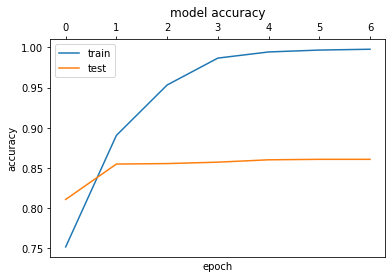

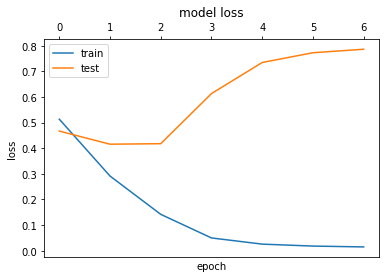

              precision    recall  f1-score   support

           0     0.8190    0.8941    0.8549       491
           1     0.8109    0.6969    0.7496       320

    accuracy                         0.8163       811
   macro avg     0.8150    0.7955    0.8022       811
weighted avg     0.8158    0.8163    0.8134       811



<Figure size 432x288 with 0 Axes>

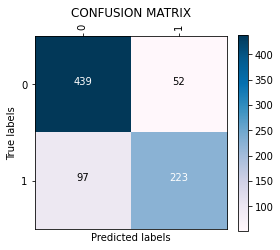


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0220
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 197s 463ms/step - loss: 0.5139 - accuracy: 0.7541 - val_loss: 0.4049 - val_accuracy: 0.8396

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 193s 452ms/step - loss: 0.2959 - accuracy: 0.8839 - val_loss: 0.4289 - val_accuracy: 0.8261

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 193s 453ms/step - loss: 0.1590 - accuracy: 0.9511 - val_loss: 0.4126 - val_accuracy: 0.8461

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 192s 452ms/step - loss: 0.0870 - accuracy: 0.9802 - val_loss: 0.4902 - val_accu

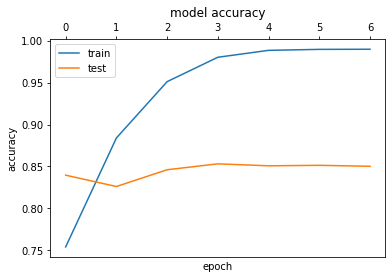

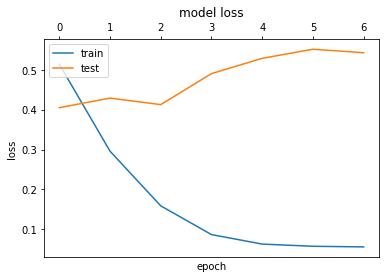

              precision    recall  f1-score   support

           0     0.8291    0.8697    0.8489       491
           1     0.7838    0.7250    0.7532       320

    accuracy                         0.8126       811
   macro avg     0.8065    0.7973    0.8011       811
weighted avg     0.8112    0.8126    0.8112       811



<Figure size 432x288 with 0 Axes>

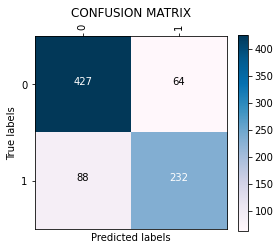


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0243
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 180s 423ms/step - loss: 0.5143 - accuracy: 0.7456 - val_loss: 0.3966 - val_accuracy: 0.8220

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 179s 421ms/step - loss: 0.2940 - accuracy: 0.8878 - val_loss: 0.4077 - val_accuracy: 0.8278

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 179s 420ms/step - loss: 0.1267 - accuracy: 0.9602 - val_loss: 0.5175 - val_accuracy: 0.8431

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 179s 420ms/step - loss: 0.0520 - accuracy: 0.9875 - val_loss: 0.6949 - val_acc

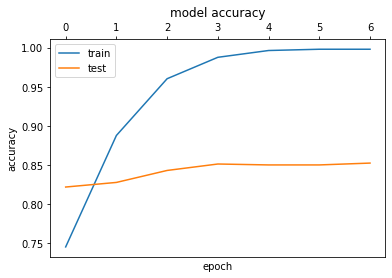

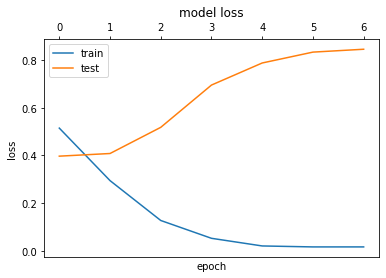

              precision    recall  f1-score   support

           0     0.8195    0.8880    0.8524       491
           1     0.8029    0.7000    0.7479       320

    accuracy                         0.8138       811
   macro avg     0.8112    0.7940    0.8002       811
weighted avg     0.8130    0.8138    0.8112       811



<Figure size 432x288 with 0 Axes>

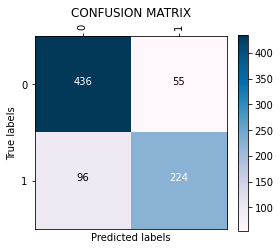


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0304
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 193s 453ms/step - loss: 0.5198 - accuracy: 0.7516 - val_loss: 0.4211 - val_accuracy: 0.8184

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 192s 451ms/step - loss: 0.3113 - accuracy: 0.8803 - val_loss: 0.3821 - val_accuracy: 0.8408

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 192s 451ms/step - loss: 0.1700 - accuracy: 0.9487 - val_loss: 0.3912 - val_accuracy: 0.8549

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 191s 448ms/step - loss: 0.1037 - accuracy: 0.9759 - val_loss: 0.4779 - val_accu

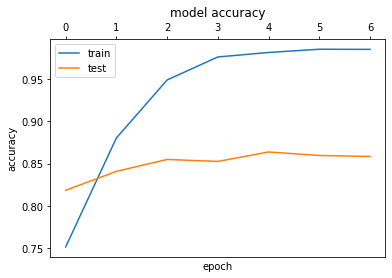

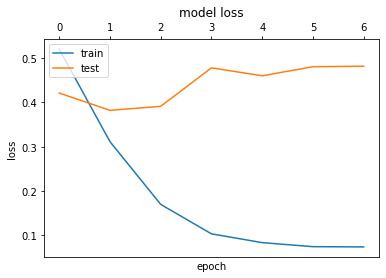

              precision    recall  f1-score   support

           0     0.8204    0.8839    0.8510       491
           1     0.7979    0.7031    0.7475       320

    accuracy                         0.8126       811
   macro avg     0.8091    0.7935    0.7992       811
weighted avg     0.8115    0.8126    0.8102       811



<Figure size 432x288 with 0 Axes>

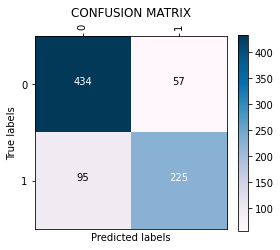


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0327
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 179s 419ms/step - loss: 0.5221 - accuracy: 0.7438 - val_loss: 0.4268 - val_accuracy: 0.8155

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 179s 419ms/step - loss: 0.2936 - accuracy: 0.8884 - val_loss: 0.3734 - val_accuracy: 0.8402

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 177s 416ms/step - loss: 0.1338 - accuracy: 0.9555 - val_loss: 0.4450 - val_accuracy: 0.8437

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 179s 419ms/step - loss: 0.0490 - accuracy: 0.9872 - val_loss: 0.6139 - val_acc

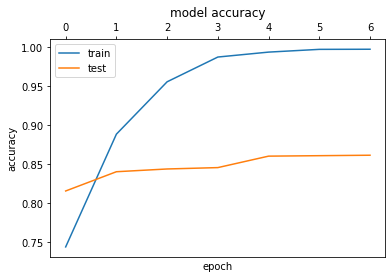

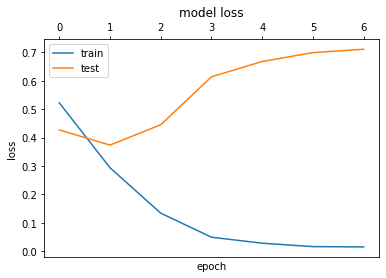

              precision    recall  f1-score   support

           0     0.8321    0.8880    0.8591       491
           1     0.8084    0.7250    0.7644       320

    accuracy                         0.8237       811
   macro avg     0.8202    0.8065    0.8118       811
weighted avg     0.8227    0.8237    0.8217       811



<Figure size 432x288 with 0 Axes>

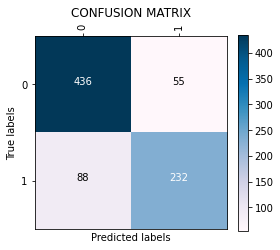


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0348
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 196s 459ms/step - loss: 0.5376 - accuracy: 0.7506 - val_loss: 0.4383 - val_accuracy: 0.8255

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 193s 453ms/step - loss: 0.3281 - accuracy: 0.8763 - val_loss: 0.3989 - val_accuracy: 0.8367

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 192s 450ms/step - loss: 0.1895 - accuracy: 0.9412 - val_loss: 0.4893 - val_accuracy: 0.8267

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 191s 448ms/step - loss: 0.1136 - accuracy: 0.9715 - val_loss: 0.4878 - val_accu

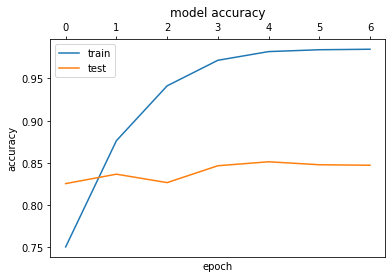

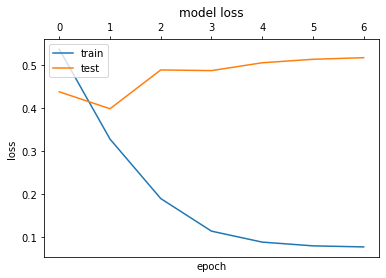

              precision    recall  f1-score   support

           0     0.8185    0.8819    0.8490       491
           1     0.7943    0.7000    0.7442       320

    accuracy                         0.8101       811
   macro avg     0.8064    0.7909    0.7966       811
weighted avg     0.8090    0.8101    0.8077       811



<Figure size 432x288 with 0 Axes>

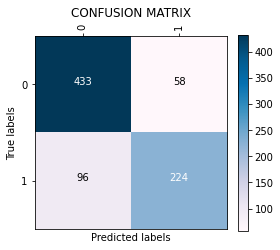


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0411
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 181s 425ms/step - loss: 0.5214 - accuracy: 0.7413 - val_loss: 0.4052 - val_accuracy: 0.8190

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 179s 421ms/step - loss: 0.3062 - accuracy: 0.8825 - val_loss: 0.3638 - val_accuracy: 0.8367

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 180s 423ms/step - loss: 0.1300 - accuracy: 0.9583 - val_loss: 0.5192 - val_accuracy: 0.8496

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 180s 422ms/step - loss: 0.0387 - accuracy: 0.9897 - val_loss: 0.6850 - val_acc

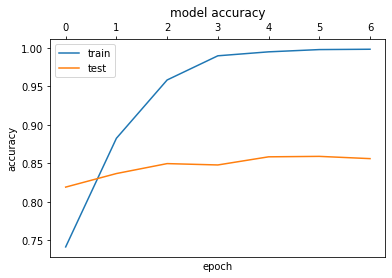

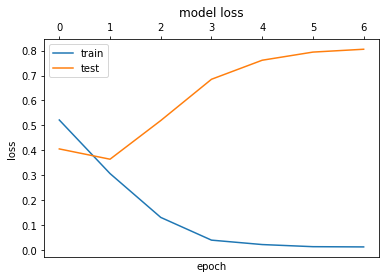

              precision    recall  f1-score   support

           0     0.8295    0.8819    0.8549       491
           1     0.7993    0.7219    0.7586       320

    accuracy                         0.8187       811
   macro avg     0.8144    0.8019    0.8068       811
weighted avg     0.8176    0.8187    0.8169       811



<Figure size 432x288 with 0 Axes>

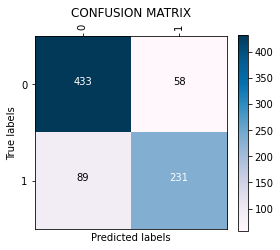


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0433
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 193s 453ms/step - loss: 0.6158 - accuracy: 0.6614 - val_loss: 0.5137 - val_accuracy: 0.7603

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 192s 450ms/step - loss: 0.4162 - accuracy: 0.8287 - val_loss: 0.4033 - val_accuracy: 0.8202

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 192s 452ms/step - loss: 0.2624 - accuracy: 0.9082 - val_loss: 0.3900 - val_accuracy: 0.8449

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 192s 452ms/step - loss: 0.1583 - accuracy: 0.9556 - val_loss: 0.3913 - val_accu

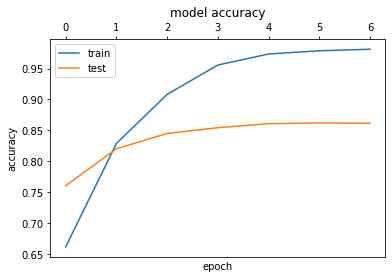

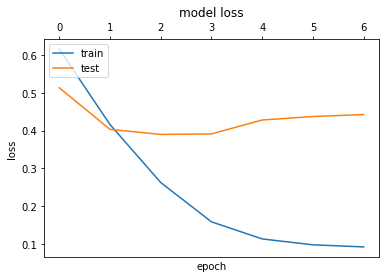

              precision    recall  f1-score   support

           0     0.8273    0.8778    0.8518       491
           1     0.7931    0.7188    0.7541       320

    accuracy                         0.8150       811
   macro avg     0.8102    0.7983    0.8029       811
weighted avg     0.8138    0.8150    0.8132       811



<Figure size 432x288 with 0 Axes>

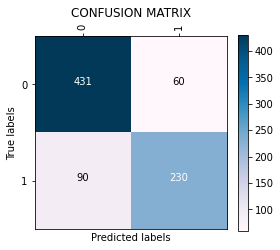


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0456
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 180s 422ms/step - loss: 0.4977 - accuracy: 0.7541 - val_loss: 0.3994 - val_accuracy: 0.8284

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 178s 418ms/step - loss: 0.2948 - accuracy: 0.8922 - val_loss: 0.3612 - val_accuracy: 0.8431

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 178s 417ms/step - loss: 0.1294 - accuracy: 0.9574 - val_loss: 0.5533 - val_accuracy: 0.8537

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 177s 416ms/step - loss: 0.0512 - accuracy: 0.9862 - val_loss: 0.6058 - val_acc

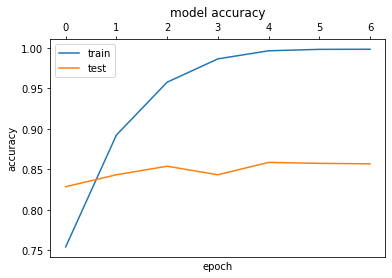

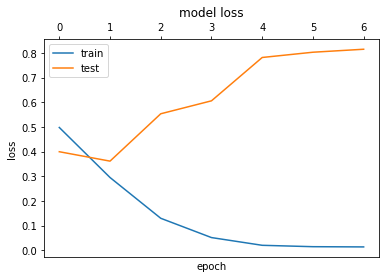

              precision    recall  f1-score   support

           0     0.8088    0.8961    0.8502       491
           1     0.8090    0.6750    0.7359       320

    accuracy                         0.8089       811
   macro avg     0.8089    0.7856    0.7931       811
weighted avg     0.8089    0.8089    0.8051       811



<Figure size 432x288 with 0 Axes>

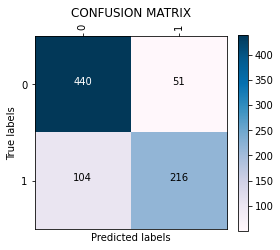


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0517
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 193s 452ms/step - loss: 0.5314 - accuracy: 0.7331 - val_loss: 0.4542 - val_accuracy: 0.7938

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 192s 450ms/step - loss: 0.3071 - accuracy: 0.8834 - val_loss: 0.3951 - val_accuracy: 0.8308

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 192s 450ms/step - loss: 0.1593 - accuracy: 0.9499 - val_loss: 0.4265 - val_accuracy: 0.8519

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 192s 451ms/step - loss: 0.0948 - accuracy: 0.9765 - val_loss: 0.4824 - val_accu

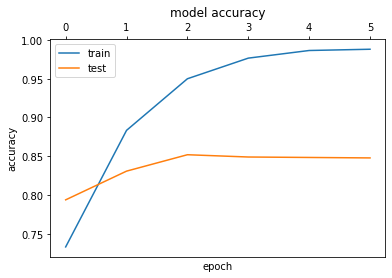

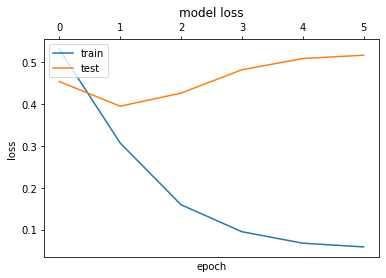

              precision    recall  f1-score   support

           0     0.8274    0.8982    0.8613       491
           1     0.8201    0.7125    0.7625       320

    accuracy                         0.8249       811
   macro avg     0.8238    0.8053    0.8119       811
weighted avg     0.8245    0.8249    0.8223       811



<Figure size 432x288 with 0 Axes>

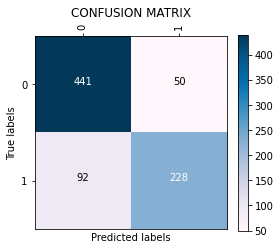


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0537
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 180s 422ms/step - loss: 0.5039 - accuracy: 0.7564 - val_loss: 0.3741 - val_accuracy: 0.8484

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 178s 418ms/step - loss: 0.2835 - accuracy: 0.8885 - val_loss: 0.3702 - val_accuracy: 0.8543

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 178s 419ms/step - loss: 0.1364 - accuracy: 0.9553 - val_loss: 0.4035 - val_accuracy: 0.8655

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 179s 419ms/step - loss: 0.0493 - accuracy: 0.9874 - val_loss: 0.6099 - val_acc

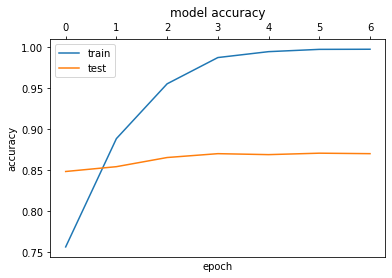

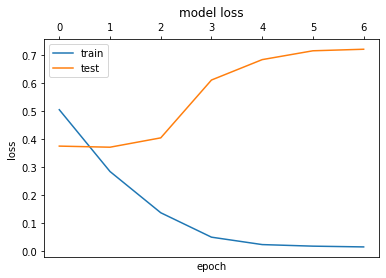

              precision    recall  f1-score   support

           0     0.8187    0.8921    0.8538       491
           1     0.8080    0.6969    0.7483       320

    accuracy                         0.8150       811
   macro avg     0.8133    0.7945    0.8011       811
weighted avg     0.8145    0.8150    0.8122       811



<Figure size 432x288 with 0 Axes>

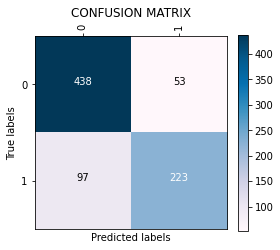


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0558
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 194s 456ms/step - loss: 0.5783 - accuracy: 0.6958 - val_loss: 0.4590 - val_accuracy: 0.7961

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 193s 453ms/step - loss: 0.3697 - accuracy: 0.8463 - val_loss: 0.4200 - val_accuracy: 0.8249

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 193s 453ms/step - loss: 0.2302 - accuracy: 0.9169 - val_loss: 0.3953 - val_accuracy: 0.8484

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 193s 452ms/step - loss: 0.1323 - accuracy: 0.9625 - val_loss: 0.4548 - val_accu

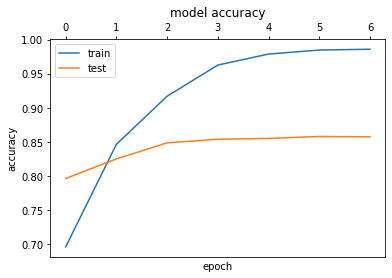

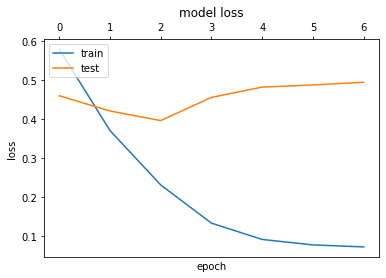

              precision    recall  f1-score   support

           0     0.8132    0.8778    0.8443       491
           1     0.7865    0.6906    0.7354       320

    accuracy                         0.8039       811
   macro avg     0.7998    0.7842    0.7899       811
weighted avg     0.8027    0.8039    0.8013       811



<Figure size 432x288 with 0 Axes>

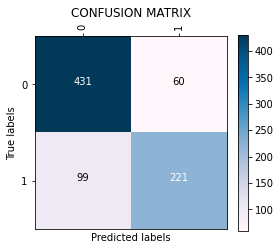


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0621
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 181s 424ms/step - loss: 0.5205 - accuracy: 0.7363 - val_loss: 0.4183 - val_accuracy: 0.8149

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 179s 421ms/step - loss: 0.2933 - accuracy: 0.8841 - val_loss: 0.4590 - val_accuracy: 0.8249

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 179s 420ms/step - loss: 0.1318 - accuracy: 0.9592 - val_loss: 0.5532 - val_accuracy: 0.8373

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 180s 422ms/step - loss: 0.0414 - accuracy: 0.9894 - val_loss: 0.7363 - val_acc

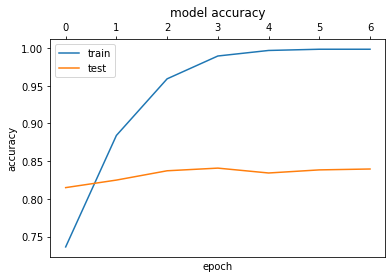

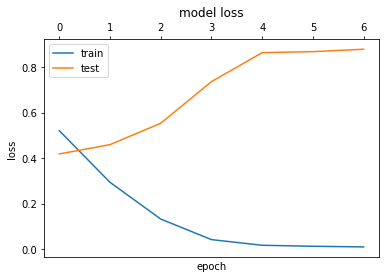

              precision    recall  f1-score   support

           0     0.8058    0.9043    0.8522       491
           1     0.8192    0.6656    0.7345       320

    accuracy                         0.8101       811
   macro avg     0.8125    0.7850    0.7933       811
weighted avg     0.8111    0.8101    0.8058       811



<Figure size 432x288 with 0 Axes>

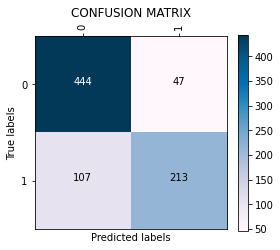


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0643
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 193s 452ms/step - loss: 0.5042 - accuracy: 0.7672 - val_loss: 0.4034 - val_accuracy: 0.8231

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 192s 451ms/step - loss: 0.2944 - accuracy: 0.8875 - val_loss: 0.3722 - val_accuracy: 0.8420

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 193s 452ms/step - loss: 0.1531 - accuracy: 0.9548 - val_loss: 0.4390 - val_accuracy: 0.8449

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 192s 451ms/step - loss: 0.0828 - accuracy: 0.9802 - val_loss: 0.4755 - val_accu

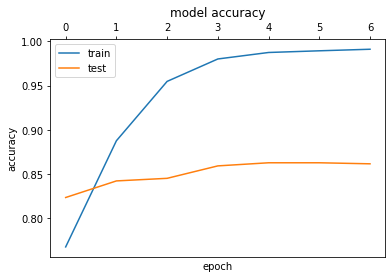

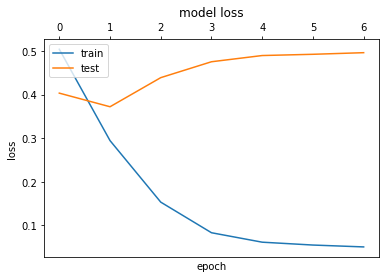

              precision    recall  f1-score   support

           0     0.8236    0.8941    0.8574       491
           1     0.8129    0.7063    0.7559       320

    accuracy                         0.8200       811
   macro avg     0.8183    0.8002    0.8066       811
weighted avg     0.8194    0.8200    0.8173       811



<Figure size 432x288 with 0 Axes>

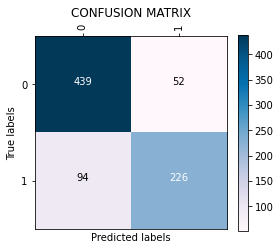


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0706
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 180s 422ms/step - loss: 0.5379 - accuracy: 0.7278 - val_loss: 0.3828 - val_accuracy: 0.8267

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 179s 420ms/step - loss: 0.3082 - accuracy: 0.8851 - val_loss: 0.3650 - val_accuracy: 0.8519

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 179s 421ms/step - loss: 0.1578 - accuracy: 0.9499 - val_loss: 0.4669 - val_accuracy: 0.8502

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 180s 421ms/step - loss: 0.0658 - accuracy: 0.9815 - val_loss: 0.6233 - val_acc

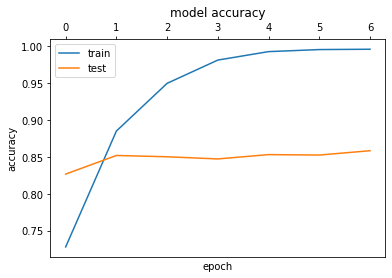

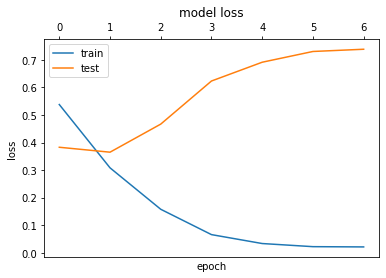

              precision    recall  f1-score   support

           0     0.8302    0.8961    0.8619       491
           1     0.8185    0.7188    0.7654       320

    accuracy                         0.8261       811
   macro avg     0.8243    0.8074    0.8136       811
weighted avg     0.8256    0.8261    0.8238       811



<Figure size 432x288 with 0 Axes>

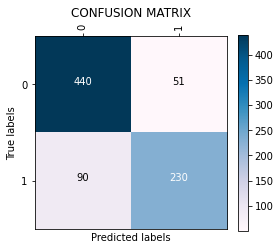


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0727
Using LSTM

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
426/426 [==============================] - 195s 458ms/step - loss: 0.5402 - accuracy: 0.7416 - val_loss: 0.4260 - val_accuracy: 0.8173

Epoch 00002: LearningRateScheduler reducing learning rate to 3.684210433244803e-05.
Epoch 2/7
426/426 [==============================] - 192s 450ms/step - loss: 0.3148 - accuracy: 0.8769 - val_loss: 0.3996 - val_accuracy: 0.8414

Epoch 00003: LearningRateScheduler reducing learning rate to 2.1491228532492336e-05.
Epoch 3/7
426/426 [==============================] - 192s 452ms/step - loss: 0.1749 - accuracy: 0.9440 - val_loss: 0.4118 - val_accuracy: 0.8561

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0375075989627634e-05.
Epoch 4/7
426/426 [==============================] - 193s 453ms/step - loss: 0.0949 - accuracy: 0.9771 - val_loss: 0.4538 - val_accu

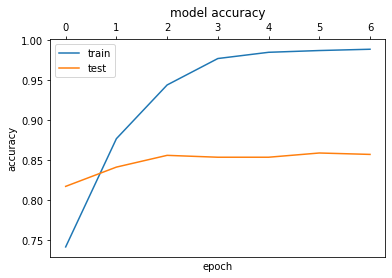

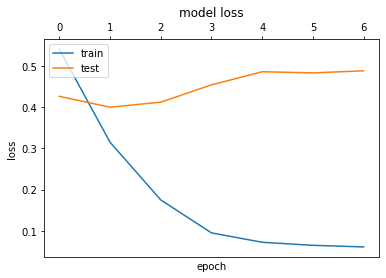

              precision    recall  f1-score   support

           0     0.8175    0.8941    0.8541       491
           1     0.8102    0.6937    0.7475       320

    accuracy                         0.8150       811
   macro avg     0.8139    0.7939    0.8008       811
weighted avg     0.8146    0.8150    0.8120       811



<Figure size 432x288 with 0 Axes>

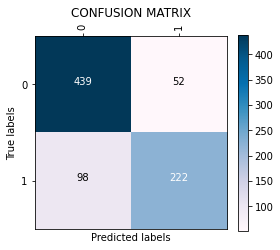


LR=5e-05, batch_size=16, dropout=0.25, optimizer=Adam
Timestamp: 20210904T0750
Using Dense

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-05.
Epoch 1/7
  9/426 [..............................] - ETA: 2:08 - loss: 0.7658 - accuracy: 0.4375

ResourceExhaustedError:  OOM when allocating tensor with shape[16,100,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node functional_35/keras_layer_17/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/transformer_encoder/StatefulPartitionedCall/transformer/layer_11/dropout_35/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1140005]

Function call stack:
train_function


In [14]:
for j in range(1,21):
        
    epochs         = 7
    optimizers     = [ Adam ]
    learning_rates = [ 5e-5, ]
    batch_sizes    = [ 16, ]
    dropouts       = [ 0.25 ]

    all_combinations = list(itertools.product(*[learning_rates, batch_sizes, dropouts, optimizers]))

    time_stamp1 = time.strftime("%Y%m%dT%H%M") 
    file_name   = f'logs/log_{time_stamp1}.txt'
    wdir        = 'ckps/current/'

    with open( file_name, 'w', encoding='utf-8' ) as f:
        experiment_name = 'NO UPSAMPLING, N0 SENTIMENT, BERT\n'
        f.write( experiment_name )
        for learning_rate, batch_size, dropout, optimizer in all_combinations:

            time_stamp = time.strftime("%Y%m%dT%H%M") 
            optimizer_name = optimizer.__module__.split('.')[-1].capitalize()
            params = f'\nLR={learning_rate}, batch_size={batch_size}, dropout={dropout}, optimizer={optimizer_name}'
            print( params )
            print( 'Timestamp:', time_stamp)
            f.write( params + '\nTimestamp: ' + time_stamp + '\n' )       

            if j%2 == 0:                
                model      = build_model( 
                                          learning_rate,                                  
                                          dropout,
                                          optimizer,
                                          max_len=maxlen,
                                        )
                print('Using LSTM')
            else:
                model      = build_model2( 
                                          learning_rate,                                  
                                          dropout,
                                          optimizer,
                                          max_len=maxlen,
                                        )
                print('Using Dense')

            early_stop = tf.keras.callbacks.EarlyStopping(
                                                           monitor='val_accuracy',
                                                           patience=3,
                                                           restore_best_weights=True,
                                                           verbose=2,
                                                         )

            reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau( 
                                                               monitor="val_loss",                                                           
                                                               patience=1,
                                                               factor=0.5,
                                                               min_lr=1e-6,
                                                               verbose=2,
                                                             )

            filepath   = wdir + time_stamp + '-epoch{epoch:02d}-val_accu_{val_accuracy:.2f}-val_loss_{val_loss:.2f}.hdf5'
            checkpoint = tf.keras.callbacks.ModelCheckpoint( 
                                                               filepath,
                                                               verbose=0,
                                                           )

            decay = 50000*learning_rate / epochs        
            def lr_time_based_decay(epoch, lr):
                return lr * 1 / (1 + decay * epoch)        
            lr_schedule = tf.keras.callbacks.LearningRateScheduler( lr_time_based_decay, verbose=2 )

            history = model.fit( X_train_encoded,
                                 y_train,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1,
                                 validation_split=0.2,
                                 callbacks=[ early_stop, lr_schedule, checkpoint ]
                                )

            score = model.evaluate(X_test_encoded, y_test, verbose=1)
            test_results = f'Test Score: {score[0]}\nTest Accuracy: {score[1]}\n'
            print( test_results )
            f.write( test_results + '\n')

            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])

            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','test'], loc='upper left')
            plt.show()

            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])

            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train','test'], loc='upper left')
            plt.show()

            # PREDICT ALL
            predictions = model.predict(X_test_encoded)
            predictions = np.round( predictions )
            clf_report = classification_report(y_test, predictions, digits=4)
            print( clf_report )
            f.write( clf_report + '\n')

            # PRINT THE CONFUSION MATRIX
            labels = list( range( len(np.unique(y_test))))
            cm = confusion_matrix(y_test, predictions)
            np.set_printoptions(precision=2)
            plt.figure()
            plot_confusion_matrix(cm, classes=labels)

            record_end = '='*70
            print( record_end )
            f.write( record_end + '\n')

In [ ]:
gc.collect()

## Appendix

In [ ]:
# to archive: !tar -zcvf data.tar.gz models

In [ ]:
# check size: !ls -lh data.tar.gz

In [ ]:
# split into smaller chunks: !split -b 150M data.tar.gz "data.tar.gz.part"

In [ ]:
# merge from chunks: cat data.tar.gz.parta* >data.tar.gz.joined